In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from yolo_threat import YoloThreat
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tune import Tuner
import pandas as pd

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
Xtrain = torch.load('../data/danger/raw/train.pt').to(device)
ytrain = torch.load('../data/danger/raw/train_labels.pt').to(device)
Xtest = torch.load('../data/danger/raw/test.pt').to(device)
ytest = torch.load('../data/danger/raw/test_labels.pt').to(device)

In [63]:
model = YoloThreat.load_new_model().to(device)
model.load_state_dict(torch.load('trained_model.pt', map_location=device))

Using cache found in /Users/harshitsingh/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-22 Python-3.12.2 torch-2.2.2 CPU

Fusing layers... 
YOLOv5n6 summary: 280 layers, 3239884 parameters, 0 gradients
Adding AutoShape... 


<All keys matched successfully>

In [64]:
tuner = Tuner(model,(Xtrain, ytrain))

In [65]:
def fgsm_attack(model, images, labels, epsilon, batch_size=32):
    """
    FGSM attack with batch processing and custom loss.

    Args:
        model: The trained model.
        images: Input data (images).
        labels: True labels.
        epsilon: Perturbation strength for FGSM.
        batch_size: Batch size for processing.

    Returns:
        Adversarial examples as a tensor.
    """
    adv_images = []
    custom_loss = tuner.get_loss(0.01)
    model.eval()  # Set model to evaluation mode for FGSM attack
    for i in range(0, images.size(0), batch_size):
        # Process a batch
        images_batch = images[i:i + batch_size].detach().clone()
        labels_batch = labels[i:i + batch_size].detach().clone()

        images_batch.requires_grad = True
        outputs = model(images_batch)
        loss = custom_loss(outputs.squeeze(-1), labels_batch.float())
        model.zero_grad()
        loss.backward()
        perturbed_batch = images_batch + epsilon * images_batch.grad.sign()
        adv_images.append(torch.clamp(perturbed_batch, 0, 1))  # Clamp to valid range

    return torch.cat(adv_images, dim=0)  # Combine all batches into a single tensor


In [66]:
def test(model_t, X, y):
    model_t.eval()
    with torch.no_grad():
        y_pred = model_t.forward(X)
        y_pred = torch.sigmoid(y_pred)
        y_pred = (y_pred > 0.5).float().reshape(-1)
        accuracy = np.mean((y_pred.cpu() == y.cpu()).numpy())

        # Calculate precision, recall, and F1 score
        y_true = y.cpu().numpy()
        y_pred = y_pred.cpu().numpy()
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        return accuracy, precision, recall, f1

In [67]:
def evaluate_with_epsilon(model, X, y, epsilons, attack_fn, attack_name):
    results = {}
    for epsilon in epsilons:
        print(f"Evaluating {attack_name} attack with epsilon={epsilon:.3f}")
        if attack_name == "Normal":
            perturbed_X = X
        else:
            perturbed_X = attack_fn(model, X, y, epsilon=epsilon)

        acc, precision, recall, f1 = test(model, perturbed_X, y)
        results[epsilon] = {
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }
        print(f"Epsilon={epsilon:.3f} | Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    return results


In [68]:
def evaluate_with_noise(model, X, y, noise_levels, attack_fn=None, epsilon=0, label="Evaluation with Noise"):
    """
    Evaluate model performance under varying noise levels, with or without FGSM attacks.

    Args:
        model: The trained model.
        X: Input data.
        y: True labels.
        noise_levels: List of noise levels to add to the input data.
        attack_fn: Adversarial attack function (e.g., FGSM), default is None for no attack.
        epsilon: Perturbation strength for FGSM, if applicable.
        label: Label for the evaluation (e.g., "Normal with Noise" or "FGSM with Noise").

    Returns:
        A dictionary of results for different noise levels.
    """
    results = {}
    for noise_level in noise_levels:
        print(f"Evaluating {label} with noise level: {noise_level:.3f}")

        if noise_level != 0:
            noisy_X = X + noise_level * torch.randn_like(X).to(X.device)
            noisy_X = torch.clamp(noisy_X, 0, 1)  # Clip values to valid range [0, 1]
        else:
            noisy_X = X

        # Handle FGSM attack (only if attack_fn is provided)
        if attack_fn:
            try:
                perturbed_X = attack_fn(model, noisy_X, y, epsilon=epsilon)
            except Exception as e:
                print(f"Error during {label} attack: {e}")
                perturbed_X = noisy_X  # Fallback to noisy input if FGSM fails
        else:
            perturbed_X = noisy_X  # For normal evaluation, only noisy data is used

        # Evaluate the model on the perturbed/noisy data
        try:
            acc, precision, recall, f1 = test(model, perturbed_X, y)
            results[noise_level] = {
                "accuracy": acc,
                "precision": precision,
                "recall": recall,
                "f1_score": f1,
            }
            print(
                f"Results (Noise={noise_level:.3f}): Accuracy={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}"
            )
        except Exception as e:
            print(f"Error during evaluation at noise level {noise_level:.3f}: {e}")
            results[noise_level] = {
                "accuracy": None,
                "precision": None,
                "recall": None,
                "f1_score": None,
            }

    return results



In [69]:
%matplotlib inline
def plot_results(results_dict, x_label, title):
    """
    Plot results for accuracy against varying noise or epsilon.

    Args:
        results_dict: Dictionary containing results for plotting.
        x_label: Label for the x-axis (e.g., "Noise Level", "Epsilon").
        title: Plot title.
    """
    plt.figure(figsize=(8, 6))
    for method, results in results_dict.items():
        x_values = list(results.keys())
        accuracies = [metrics["accuracy"] for metrics in results.values()]
        plt.plot(x_values, accuracies, marker='o', label=method)

    plt.xlabel(x_label)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [70]:
epsilons = [0, 0.2, 0.3]
noise_levels = [0, 0.1, 0.3]

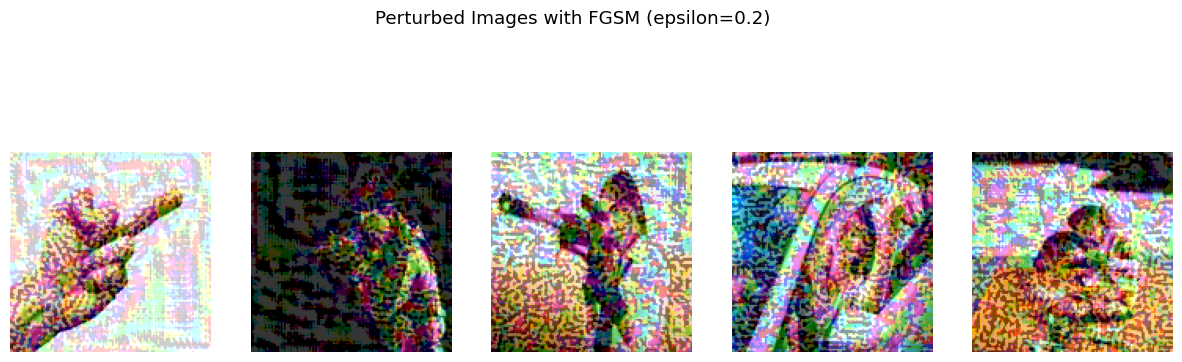

In [71]:

epsilon = 0.2
perturbed_images = fgsm_attack(model, Xtest[:5], ytest[:5], epsilon)

# Plot the perturbed images
plt.figure(figsize=(15, 5))  # Adjust the figure size for better visualization
for i in range(5):
    plt.subplot(1, 5, i + 1)
    # Detach the tensor and convert to NumPy
    plt.imshow(perturbed_images[i].detach().cpu().numpy().transpose(1, 2, 0))
    plt.axis("off")
plt.suptitle(f"Perturbed Images with FGSM (epsilon={epsilon})")
plt.show()

In [73]:
print("Evaluating normal model performance...")
accuracy, precision, recall, f1 = test(model, Xtest, ytest)
normal_results = {0: {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}}

Evaluating normal model performance...


In [74]:
normal_results
normal_results_df = pd.DataFrame.from_dict(normal_results, orient='index').reset_index()

# Rename the 'index' column to 'Epsilon'
normal_results_df.rename(columns={'index': 'Epsilon'}, inplace=True)
normal_results_df

,Epsilon,accuracy,precision,recall,f1_score
0,0,0.691533,0.859083,0.461258,0.600237


In [75]:
# normal_noise_results = evaluate_with_noise(model, Xtest, ytest, noise_levels, test)
normal_noise_results = evaluate_with_noise(model, Xtest, ytest, noise_levels, attack_fn=None, label="Normal with Noise")

Evaluating Normal with Noise with noise level: 0.000


Results (Noise=0.000): Accuracy=0.6915, Precision=0.8591, Recall=0.4613, F1=0.6002
Evaluating Normal with Noise with noise level: 0.100
Results (Noise=0.100): Accuracy=0.6549, Precision=0.7780, Recall=0.4376, F1=0.5601
Evaluating Normal with Noise with noise level: 0.300
Results (Noise=0.300): Accuracy=0.5803, Precision=0.6289, Recall=0.4002, F1=0.4891


In [76]:
normal_noise_results
normal_noise_results_df = pd.DataFrame.from_dict(normal_noise_results, orient='index').reset_index()
normal_noise_results_df.rename(columns={'index': 'Noise'}, inplace=True)
normal_noise_results_df

,Noise,accuracy,precision,recall,f1_score
0,0.0,0.691533,0.859083,0.461258,0.600237
1,0.1,0.654920,0.777958,0.437557,0.560093
2,0.3,0.580320,0.628940,0.400182,0.489136


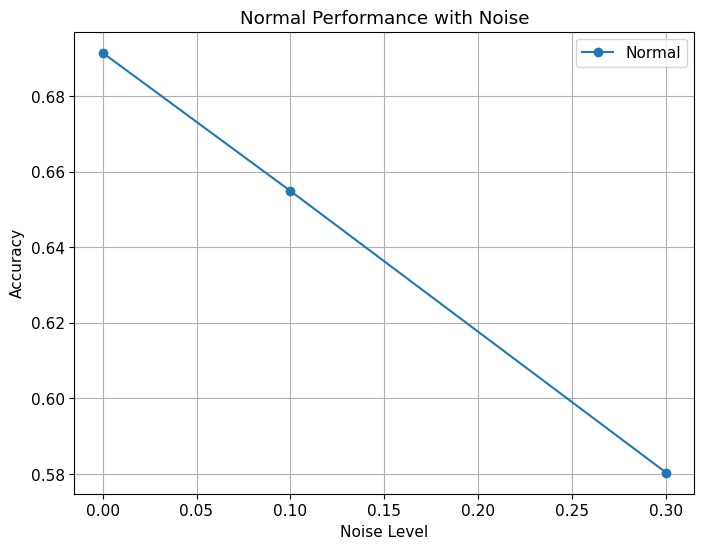

In [77]:
plot_results({"Normal": normal_noise_results}, "Noise Level", "Normal Performance with Noise")

In [78]:
fgsm_epsilon_results = evaluate_with_epsilon(model, Xtest, ytest, epsilons, fgsm_attack, "FGSM")
fgsm_epsilon_results

Evaluating FGSM attack with epsilon=0.000
Epsilon=0.000 | Acc: 0.6915, Precision: 0.8591, Recall: 0.4613, F1: 0.6002
Evaluating FGSM attack with epsilon=0.200
Epsilon=0.200 | Acc: 0.5011, Precision: 0.5100, Recall: 0.1632, F1: 0.2472
Evaluating FGSM attack with epsilon=0.300
Epsilon=0.300 | Acc: 0.5071, Precision: 0.5476, Recall: 0.1048, F1: 0.1760


{0: {'accuracy': 0.691533180778032,
  'precision': 0.8590831918505942,
  'recall': 0.4612579762989973,
  'f1_score': 0.6002372479240806},
 0.2: {'accuracy': 0.5011441647597255,
  'precision': 0.50997150997151,
  'recall': 0.16317228805834094,
  'f1_score': 0.2472375690607735},
 0.3: {'accuracy': 0.5070938215102975,
  'precision': 0.5476190476190477,
  'recall': 0.1048313582497721,
  'f1_score': 0.17597551644988524}}

In [79]:
fgsm_epsilon_results_df = pd.DataFrame.from_dict(fgsm_epsilon_results, orient='index').reset_index()
fgsm_epsilon_results_df.rename(columns={'index': 'Epsilon'}, inplace=True)
fgsm_epsilon_results_df

,Epsilon,accuracy,precision,recall,f1_score
0,0.0,0.691533,0.859083,0.461258,0.600237
1,0.2,0.501144,0.509972,0.163172,0.247238
2,0.3,0.507094,0.547619,0.104831,0.175976


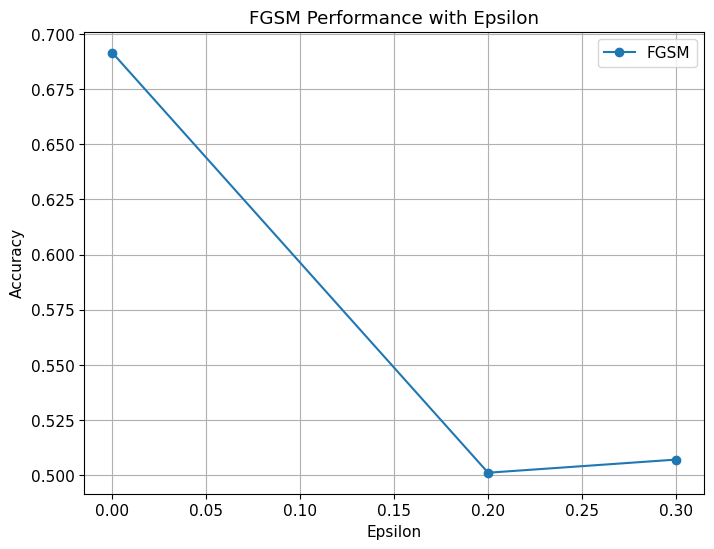

In [80]:
plot_results({"FGSM": fgsm_epsilon_results}, "Epsilon", "FGSM Performance with Epsilon")

In [81]:
fgsm_noise_results = evaluate_with_noise(model, Xtest, ytest, noise_levels, attack_fn=fgsm_attack, epsilon=0.1, label="FGSM with Noise")

Evaluating FGSM with Noise with noise level: 0.000
Results (Noise=0.000): Accuracy=0.4330, Precision=0.3591, Recall=0.1650, F1=0.2261
Evaluating FGSM with Noise with noise level: 0.100
Results (Noise=0.100): Accuracy=0.3350, Precision=0.2120, Recall=0.1194, F1=0.1528
Evaluating FGSM with Noise with noise level: 0.300
Results (Noise=0.300): Accuracy=0.2064, Precision=0.1073, Recall=0.0793, F1=0.0912


In [82]:
fgsm_noise_results_df = pd.DataFrame.from_dict(fgsm_noise_results, orient='index').reset_index()
fgsm_noise_results_df.rename(columns={'index': 'Noise'}, inplace=True)
fgsm_noise_results_df

,Noise,accuracy,precision,recall,f1_score
0,0.0,0.432952,0.359127,0.164995,0.226109
1,0.1,0.335011,0.211974,0.119417,0.152770
2,0.3,0.206407,0.107275,0.079307,0.091195


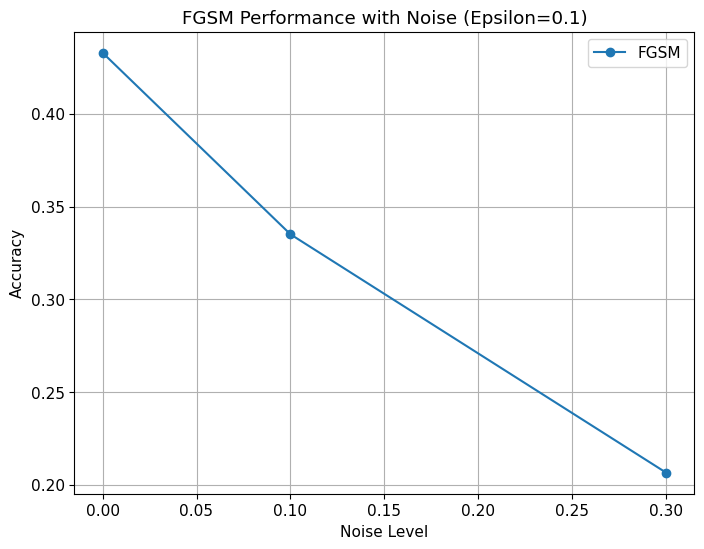

In [83]:
plot_results({"FGSM": fgsm_noise_results}, "Noise Level", "FGSM Performance with Noise (Epsilon=0.1)")

In [84]:
def adversarial_training_with_tuner(
    tuner,
    model,
    Xtrain,
    ytrain,
    epsilon=0.1,
    lam=0.01,
    batch_size=64,
    epochs=30,
    lr=0.001
):
    """
    Adversarial training using FGSM attacks.

    Args:
        tuner: Tuner class for training.
        model: Neural network model.
        Xtrain, ytrain: Training data and labels.
        epsilon: Perturbation strength for FGSM.
        lam: Regularization weight for custom loss.
        batch_size: Batch size for training.
        epochs: Number of epochs for training.
        lr: Learning rate for the optimizer.

    Returns:
        Trained model.
    """

    # Prepare data loader for clean examples
    train_dataset = TensorDataset(Xtrain, ytrain)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    combined_X = []
    combined_y = []

    # Generate combined clean and adversarial examples
    model.eval()  # Set model to evaluation mode for FGSM attack
    for X_batch, y_batch in train_loader:
        # Append clean examples
        combined_X.append(X_batch)
        combined_y.append(y_batch)

        # Generate FGSM adversarial examples using the custom loss
        adv_X = fgsm_attack(
            model, X_batch, y_batch, epsilon=epsilon, batch_size=batch_size
        )
        combined_X.append(adv_X)
        combined_y.append(y_batch)

    # Concatenate clean and adversarial examples
    combined_X = torch.cat(combined_X, dim=0)
    combined_y = torch.cat(combined_y, dim=0)

    # Perform adversarial training using tuner
    trained_model = tuner.tune(
        optimizer=optim.Adam,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        lam=lam,
    )

    return trained_model

In [85]:
trained_model = adversarial_training_with_tuner(
    tuner=tuner,
    model=tuner.model,
    Xtrain=Xtrain,
    ytrain=ytrain,
    epsilon=0.1,
    lam=0.01,
    batch_size=128,
    epochs=2,
    lr=0.001
)

Epoch 0, Batch 13, Loss: 0.8586074113845825
Validation Loss: 14.446551084518433
Epoch 1, Batch 13, Loss: 0.7414630651473999
Validation Loss: 12.593751311302185


In [86]:
# Save the trained model
torch.save(trained_model.state_dict(), "adversarial_trained_model.pt")
print("Trained model saved as 'adversarial_trained_model.pt'.")

Trained model saved as 'adversarial_trained_model.pt'.


In [87]:
print("Evaluating normal model performance...")
accuracy, precision, recall, f1 = test(trained_model, Xtest, ytest)
normal_results_adversarial = {0: {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}}
normal_results_adversarial

Evaluating normal model performance...


{0: {'accuracy': 0.631121281464531,
  'precision': 0.6081784386617101,
  'recall': 0.7456700091157703,
  'f1_score': 0.6699426699426699}}

In [88]:
normal_results_adversarial_df = pd.DataFrame.from_dict(normal_results_adversarial, orient='index').reset_index()

# Rename the 'index' column to 'Epsilon'
normal_results_adversarial_df.rename(columns={'index': 'Epsilon'}, inplace=True)
normal_results_adversarial_df

,Epsilon,accuracy,precision,recall,f1_score
0,0,0.631121,0.608178,0.74567,0.669943


In [89]:

normal_noise_results_adversarial = evaluate_with_noise(trained_model, Xtest, ytest, noise_levels, attack_fn=None, label="Normal with Noise")

Evaluating Normal with Noise with noise level: 0.000
Results (Noise=0.000): Accuracy=0.6311, Precision=0.6082, Recall=0.7457, F1=0.6699
Evaluating Normal with Noise with noise level: 0.100
Results (Noise=0.100): Accuracy=0.5890, Precision=0.5699, Recall=0.7393, F1=0.6437
Evaluating Normal with Noise with noise level: 0.300
Results (Noise=0.300): Accuracy=0.5341, Precision=0.5198, Recall=0.9471, F1=0.6712


In [90]:
normal_noise_results_adversarial
normal_noise_results_adversarial_df = pd.DataFrame.from_dict(normal_noise_results_adversarial, orient='index').reset_index()

# Rename the 'index' column to 'Epsilon'
normal_noise_results_adversarial_df.rename(columns={'index': 'Noise'}, inplace=True)
normal_noise_results_adversarial_df

,Noise,accuracy,precision,recall,f1_score
0,0.0,0.631121,0.608178,0.745670,0.669943
1,0.1,0.589016,0.569923,0.739289,0.643651
2,0.3,0.534096,0.519760,0.947129,0.671189


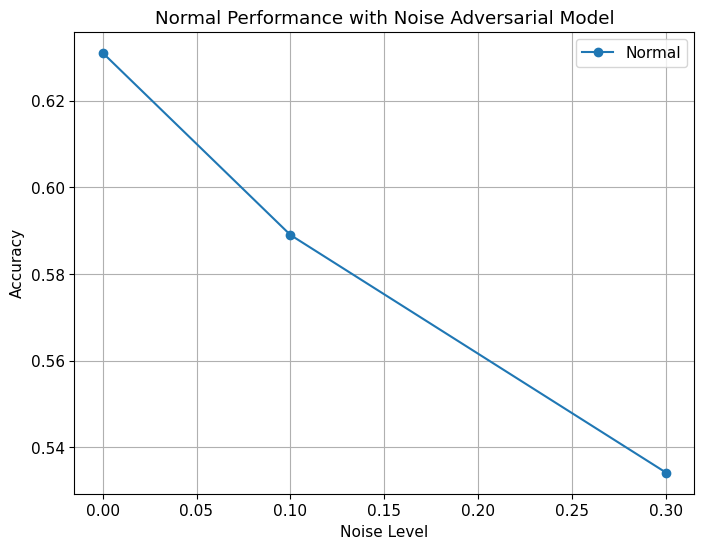

In [91]:
plot_results({"Normal": normal_noise_results_adversarial}, "Noise Level", "Normal Performance with Noise Adversarial Model")

In [92]:
fgsm_epsilon_results_adversarial = evaluate_with_epsilon(trained_model, Xtest, ytest, epsilons, fgsm_attack, "FGSM")
fgsm_epsilon_results_adversarial

Evaluating FGSM attack with epsilon=0.000
Epsilon=0.000 | Acc: 0.6311, Precision: 0.6082, Recall: 0.7457, F1: 0.6699
Evaluating FGSM attack with epsilon=0.200
Epsilon=0.200 | Acc: 0.4595, Precision: 0.4796, Recall: 0.8997, F1: 0.6257
Evaluating FGSM attack with epsilon=0.300
Epsilon=0.300 | Acc: 0.4961, Precision: 0.4991, Recall: 0.9845, F1: 0.6624


{0: {'accuracy': 0.631121281464531,
  'precision': 0.6081784386617101,
  'recall': 0.7456700091157703,
  'f1_score': 0.6699426699426699},
 0.2: {'accuracy': 0.4594965675057208,
  'precision': 0.47959183673469385,
  'recall': 0.8997265268915223,
  'f1_score': 0.6256735340729002},
 0.3: {'accuracy': 0.49610983981693363,
  'precision': 0.49907578558225507,
  'recall': 0.9845031905195989,
  'f1_score': 0.6623735050597976}}

In [93]:
fgsm_epsilon_results_adversarial_df = pd.DataFrame.from_dict(fgsm_epsilon_results_adversarial, orient='index').reset_index()
fgsm_epsilon_results_adversarial_df.rename(columns={'index': 'Epsilon'}, inplace=True)
fgsm_epsilon_results_adversarial_df

,Epsilon,accuracy,precision,recall,f1_score
0,0.0,0.631121,0.608178,0.745670,0.669943
1,0.2,0.459497,0.479592,0.899727,0.625674
2,0.3,0.496110,0.499076,0.984503,0.662374


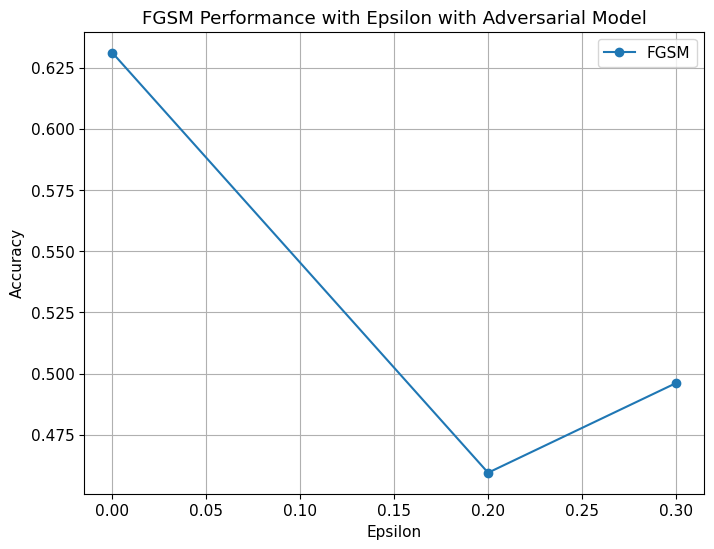

In [94]:
plot_results({"FGSM": fgsm_epsilon_results_adversarial}, "Epsilon", "FGSM Performance with Epsilon with Adversarial Model")

In [95]:
fgsm_noise_results_adversarial = evaluate_with_noise(trained_model, Xtest, ytest, noise_levels, attack_fn=fgsm_attack, epsilon=0.1, label="FGSM with Noise")

Evaluating FGSM with Noise with noise level: 0.000
Results (Noise=0.000): Accuracy=0.3062, Precision=0.3708, Recall=0.5479, F1=0.4422
Evaluating FGSM with Noise with noise level: 0.100
Results (Noise=0.100): Accuracy=0.2330, Precision=0.3143, Recall=0.4467, F1=0.3690
Evaluating FGSM with Noise with noise level: 0.300
Results (Noise=0.300): Accuracy=0.2124, Precision=0.2990, Recall=0.4230, F1=0.3503


In [96]:
fgsm_noise_results_adversarial_df = pd.DataFrame.from_dict(fgsm_noise_results_adversarial, orient='index').reset_index()
fgsm_noise_results_adversarial_df.rename(columns={'index': 'Noise'}, inplace=True)
fgsm_noise_results_adversarial_df

,Noise,accuracy,precision,recall,f1_score
0,0.0,0.306178,0.370759,0.547858,0.442237
1,0.1,0.232952,0.314304,0.446673,0.368976
2,0.3,0.212357,0.298969,0.422972,0.350321


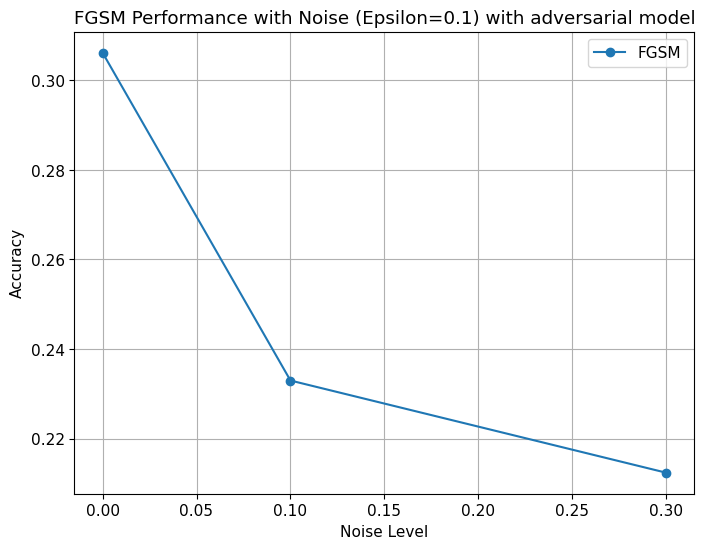

In [97]:
plot_results({"FGSM": fgsm_noise_results_adversarial}, "Noise Level", "FGSM Performance with Noise (Epsilon=0.1) with adversarial model")